In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import importlib
import os
import itertools

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
ecc_list = ['04', '05', '06']

In [5]:
def get_orbit(Rs, Vv, ecc):
    output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc+'/output'
    orbit = {}
    orbit['Time'] = []
    orbit['Orbit'] = []
    for idx in np.arange(320+1):
        fname = output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5'
        
        if not os.path.exists(fname):
            print('got to idx='+str(idx-1)+' for Rs,Vv,ecc='+Rs+','+Vv+','+ecc)
            break
        
        t = h5.File(fname, mode='r')
        orbit['Time'].append(t['Header'].attrs['Time'])
        SubhaloPos = t['Subhalo/SubhaloPos'][:]
        if len(SubhaloPos) > 1:
            orbit['Orbit'].append(SubhaloPos[1] - SubhaloPos[0])
        else:
            orbit['Orbit'].append(np.array([0., 0., 0.]))
        t.close()
    
    for k in orbit.keys():
        orbit[k] = np.array(orbit[k])
    
    orbit['Rsep'] = np.linalg.norm(orbit['Orbit'], axis=1)
        
    return orbit

In [5]:
orbits = {}
for Rs, Vv, ecc in tqdm(itertools.product(Rs_list, Vv_list, ecc_list)):
    if Rs not in orbits.keys():
        orbits[Rs] = {}
    if Vv not in orbits[Rs].keys():
        orbits[Rs][Vv] = {}
    orbits[Rs][Vv][ecc] = get_orbit(Rs, Vv, ecc)            

6it [01:31, 15.33s/it]

KeyboardInterrupt



In [13]:
fig, axs = plt.subplots(2, 3, figsize=(textwidth, 0.4*textwidth), height_ratios=[1, 1.5])

############ vary Rs
orbit = orbits['129']['129']['05']
axs[0][0].plot(orbit['Orbit'][:,0], orbit['Orbit'][:,1], c='k', zorder=10)
axs[1][0].plot(orbit['Time'], orbit['Rsep'], c='k', zorder=10)

orbit = orbits['116']['129']['05']
axs[0][0].plot(orbit['Orbit'][:,0], orbit['Orbit'][:,1], c=tb_c[0])
axs[1][0].plot(orbit['Time'], orbit['Rsep'], c=tb_c[0])

orbit = orbits['142']['129']['05']
axs[0][0].plot(orbit['Orbit'][:,0], orbit['Orbit'][:,1], c=tb_c[2])
axs[1][0].plot(orbit['Time'], orbit['Rsep'], c=tb_c[2])

############ vary Vv
orbit = orbits['129']['129']['05']
axs[0][1].plot(orbit['Orbit'][:,0], orbit['Orbit'][:,1], c='k', zorder=10)
axs[1][1].plot(orbit['Time'], orbit['Rsep'], c='k', zorder=10)

orbit = orbits['129']['116']['05']
axs[0][1].plot(orbit['Orbit'][:,0], orbit['Orbit'][:,1], c=tb_c[0])
axs[1][1].plot(orbit['Time'], orbit['Rsep'], c=tb_c[0])

orbit = orbits['129']['142']['05']
axs[0][1].plot(orbit['Orbit'][:,0], orbit['Orbit'][:,1], c=tb_c[2])
axs[1][1].plot(orbit['Time'], orbit['Rsep'], c=tb_c[2])

############ vary ecc
orbit = orbits['129']['129']['05']
axs[0][2].plot(orbit['Orbit'][:,0], orbit['Orbit'][:,1], c='k', zorder=10)
axs[1][2].plot(orbit['Time'], orbit['Rsep'], c='k', zorder=10)

orbit = orbits['129']['129']['04']
axs[0][2].plot(orbit['Orbit'][:,0], orbit['Orbit'][:,1], c=tb_c[0])
axs[1][2].plot(orbit['Time'], orbit['Rsep'], c=tb_c[0])

orbit = orbits['129']['129']['06']
axs[0][2].plot(orbit['Orbit'][:,0], orbit['Orbit'][:,1], c=tb_c[2])
axs[1][2].plot(orbit['Time'], orbit['Rsep'], c=tb_c[2])

for ax in axs[0].ravel():
    ax.set(xlim=(-150, 100), ylim=(-50, 50))
    ax.set(aspect='equal')
    ax.set(xlabel=r'$x\,[\,\textrm{kpc}\,]$', ylabel=r'$y\,[\,\textrm{kpc}\,]$')
    ax.set(xticks=np.arange(-150, 100+1, 50))

axs[0][0].set_title(r'$\textrm{vary } R_0$')
axs[0][1].set_title(r'$\textrm{vary } V_0$')
axs[0][2].set_title(r'$\textrm{vary } \eta$')

# for ax in axs[1]:
    # Direct use of textcolor with HTML color definition in LaTeX
    # text_str = r'\textcolor[HTML]{'+tb_c[2].lstrip('#')+'}{+}' + r'/\textcolor[HTML]{'+tb_c[0].lstrip('#')+'}{-}'
    # ax.text(0.95, 0.95, text_str, transform=ax.transAxes, ha='right', va='top', fontsize=12)

for ax in axs[1]:
    # plus_color = hex_to_rgb_latex(tb_c[2])  # Convert color for '+'
    # minus_color = hex_to_rgb_latex(tb_c[0])  # Convert color for '-'
    # print(plus_color)
    # text_str = r'\textcolor[rgb]' + plus_color + '{+}' + r'\textcolor{black}{/}' + r'\textcolor[rgb]' + minus_color + '{-}'
    # text_str = r'\pluscolor{+}/\minuscolor{-}'
    # ax.text(0.95, 0.95, text_str, transform=ax.transAxes, ha='right', va='top', fontsize=12)

    ax.set(xlim=(0, 4), xticks=np.arange(0, 4+1, 1), xlabel=r'$t\,[\,\textrm{Gyr}\,]$')
    ax.set(ylim=(0, 150), ylabel=r'$\textrm{separation}\,[\,\textrm{kpc}\,]$')

fig.tight_layout()

fig.savefig('orbit_param.pdf')

In [6]:
orbit0 = get_orbit('142', '116', '04')
orbit1 = get_orbit('129', '116', '04')

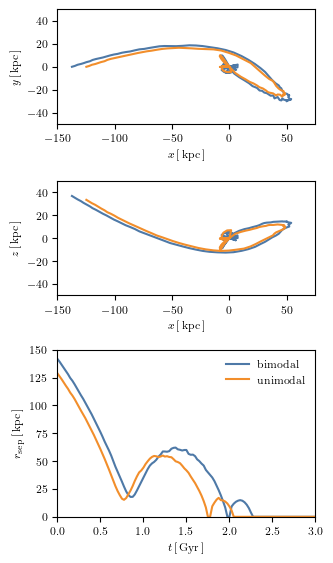

In [42]:
fig, axs = plt.subplots(3, 1, figsize=(columnwidth, 1.7*columnwidth),
                              height_ratios=[2, 2, 2.8])

axs[0].plot(orbit0['Orbit'][:,0], orbit0['Orbit'][:,1], c=tb_c[0])
axs[0].plot(orbit1['Orbit'][:,0], orbit1['Orbit'][:,1], c=tb_c[1])
axs[0].set(xlim=(-150, 75), ylim=(-50, 50))
axs[0].set(xlabel=r'$x\,[\,\textrm{kpc}\,]$')
axs[0].set(ylabel=r'$y\,[\,\textrm{kpc}\,]$')
axs[0].set_aspect('equal')

axs[1].plot(orbit0['Orbit'][:,0], orbit0['Orbit'][:,2], c=tb_c[0])
axs[1].plot(orbit1['Orbit'][:,0], orbit1['Orbit'][:,2], c=tb_c[1])
axs[1].set(xlim=(-150, 75), ylim=(-50, 50))
axs[1].set(xlabel=r'$x\,[\,\textrm{kpc}\,]$')
axs[1].set(ylabel=r'$z\,[\,\textrm{kpc}\,]$')
axs[1].set_aspect('equal')

axs[2].plot(orbit0['Time'], orbit0['Rsep'], c=tb_c[0], label=r'$\textrm{bimodal}$')
axs[2].plot(orbit1['Time'], orbit1['Rsep'], c=tb_c[1], label=r'$\textrm{unimodal}$')
axs[2].set(xlim=(0, 3), ylim=(0, 150))
axs[2].set(xlabel=r'$t\,[\,\textrm{Gyr}\,]$')
axs[2].set(ylabel=r'$r_{\textrm{sep}}\,[\,\textrm{kpc}\,]$')
axs[2].set_aspect('auto')
axs[2].legend(frameon=False)

fig.tight_layout()
fig.savefig('orbit.pdf')
plt.show()

In [10]:
orbit0.keys()

dict_keys(['Time', 'Orbit', 'Rsep'])